In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
from numpy import *
import os
from random import shuffle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
dataset = ImageFolder("C:/Data",
                      transform = transforms.Compose([transforms.Resize((200,200)), transforms.ToTensor(), 
                                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), transforms.Grayscale(num_output_channels=1)]))

In [3]:
training_data, testing_data = train_test_split(dataset, test_size=0.2, random_state=0)
print(f"Length of Train Data : {len(training_data)}")
print(f"Length of Test Data : {len(testing_data)}")

Length of Train Data : 378
Length of Test Data : 95


In [4]:
from torch.utils.data.dataloader import DataLoader
#train_dl = DataLoader(training_data, batch_size=3, shuffle = True, num_workers = 4, pin_memory = True)
#test_dl = DataLoader(testing_data, batch_size=1, num_workers = 4, pin_memory = True)


loaders = {
            'train' : torch.utils.data.DataLoader(training_data, 
                                          batch_size=10, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(testing_data, 
                                          batch_size=10, 
                                          shuffle=True, 
                                          num_workers=1),
}
print (loaders)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x0000024751961100>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x0000024751961130>}


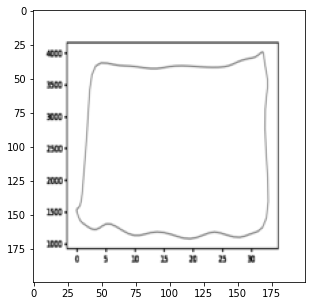

In [5]:
dataiter = iter(loaders['train'])
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[1])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
plt.show()

In [6]:
import torch.nn as nn
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(32, 64, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 50 classes
        self.out1 = nn.Linear(64 * 25 * 25, 2500)
        self.out2 = nn.Linear(2500, 50)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # flatten the output of conv2 to (batch_size, 32 * 50 * 50)
        x = x.view(-1, 40000)
        x = F.relu(self.out1(x))
        x = F.dropout(x, training=self.training)
        #x = self.out2(x)
        #x = x.view(x.size(0), -1)       
        output = self.out2(x)
      
        
        return output, x    
cnn = CNN()
print(cnn)


loss_func = nn.CrossEntropyLoss()   
loss_func


from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.001)   
optimizer

losses = []
from torch.autograd import Variable
num_epochs = 5
def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
    print(total_step)
    
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            losses.append(loss.item())
            b_x = b_x.float()
            b_y = b_y.long()
            #print(losses)
          
            
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 10 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
               

train(num_epochs, cnn, loaders)

def test():
    import torch.nn as nn
    #class CNN(nn.Module):
        #cnn = CNN()
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            testoutp, lstlayr = cnn(images)
            predicy = torch.max(testoutp, 1)[1].data.squeeze()
            accu = (predicy == labels).sum().item() / float(labels.size(0))
            pass
            print(' Accuracy of the model  %.2f' % accu)
test()

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out1): Linear(in_features=40000, out_features=2500, bias=True)
  (out2): Linear(in_features=2500, out_features=50, bias=True)
)
38
Epoch [1/5], Step [10/38], Loss: 1.8249
Epoch [1/5], Step [20/38], Loss: 2.0459
Epoch [1/5], Step [30/38], Loss: 1.7673
Epoch [2/5], Step [10/38], Loss: 0.8229
Epoch [2/5], Step [20/38], Loss: 0.5158
Epoch [2/5], Step [30/38], Loss: 0.0037
Epoch [3/5], Ste

NameError: name 'learning_rate' is not defined

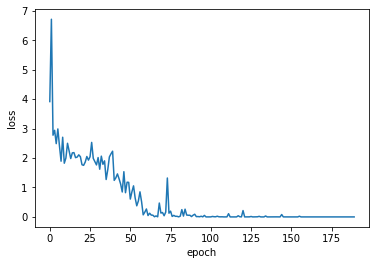

In [7]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()

In [8]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in loaders['test']:
        b_x = Variable(images)   # batch x
        b_y = Variable(labels)   # batch y
        output = cnn(b_x)[0]               
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy: {} %'.format(100 * correct / total))

Accuracy: 100.0 %


In [9]:
sample = next(iter(loaders['test']))
imgs, lbls = sample
actual_number = lbls[:15].numpy()
actual_number

array([1, 0, 7, 2, 0, 3, 6, 7, 1, 3], dtype=int64)

In [10]:
test_output, last_layer = cnn(imgs[:15])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [1 0 7 2 0 3 6 7 1 3]
Actual number: [1 0 7 2 0 3 6 7 1 3]


In [11]:
examples = enumerate(loaders['test'])
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([10, 1, 200, 200])

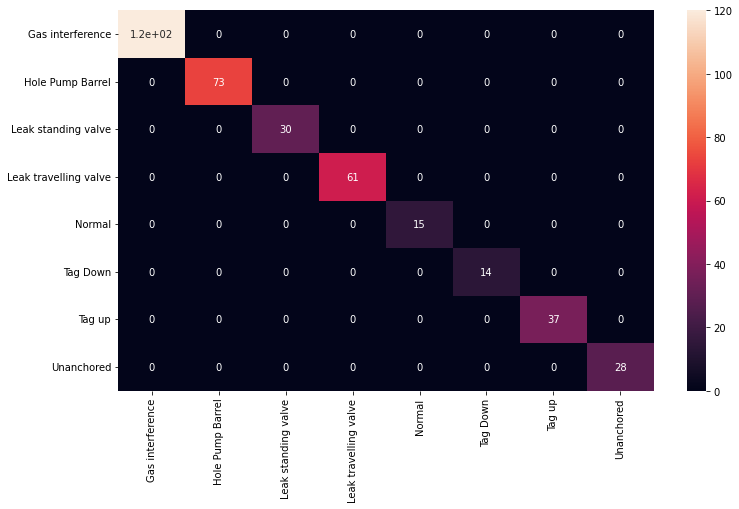

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in (loaders['train']):
        output, x = cnn(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Gas interference', 'Hole Pump Barrel', 'Leak standing valve', 'Leak travelling valve', 'Normal', 'Tag Down', 'Tag up', 'Unanchored')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [17]:
examples = enumerate(loaders['test'])
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([10, 1, 200, 200])

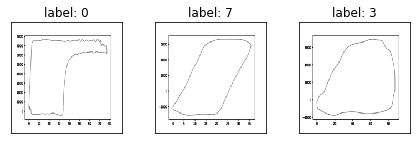

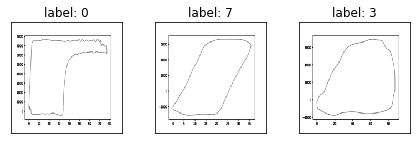

In [25]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(3):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("label: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig